In [1]:
import pandas as pd
from sklearn import model_selection, preprocessing
from sklearn import tree, linear_model, svm, ensemble, metrics
import matplotlib
from matplotlib import pyplot as plt
import xgboost as xgb
import scipy
import numpy as np
from pprint import pprint as pp

import compare_y
import cross_validation_result as cvr
import ML_helper

%matplotlib inline

In [2]:
def PSL_simulation_result(result_types, legends, title="Comparing simulation result"):
    TRUTH = "../psl/data/simulation/{0}/"
    INFER = "../psl/result/simulation/{0}/{1}/"
    MATRIX = "../data/similuated_matrix_{0}.tsv"

    Classifiers = {"XGBoost": xgb.XGBRegressor(n_estimators=100),
                   "Linear Regression": linear_model.LinearRegression()}


    results = {"mse": {"mean": pd.DataFrame(index=["linear", "random"]), 
                       "error": pd.DataFrame(index=["linear", "random"])},
               "rho": {"mean": pd.DataFrame(index=["linear", "random"]), 
                       "error": pd.DataFrame(index=["linear", "random"])}}

    for data_type in ["linear", "random"]:
        for PSL_type in result_types:
            truth_file = TRUTH.format(data_type)
            infer_file = INFER.format(data_type, PSL_type)
            PSL_accus = cvr.cross_val_result(truth_file, infer_file)        
            for accu_type, accu in {"mse": PSL_accus[0], "rho": PSL_accus[1]}.iteritems():
                results[accu_type]["mean"].set_value(data_type, "PSL_" + PSL_type, np.mean(accu))
                results[accu_type]["error"].set_value(data_type, "PSL_" + PSL_type, np.std(accu))
        matrix_file = MATRIX.format(data_type)
        X, Y = ML_helper.load_data(matrix_file)
        X = preprocessing.PolynomialFeatures(2).fit_transform(X)
        ML_accus = ML_helper.run_cross_val(X, Y, Classifiers, n_fold=6)
        for accu_type, accu in {"mse": ML_accus[0], "rho": ML_accus[1]}.iteritems():
            for algo in Classifiers.keys():
                results[accu_type]["mean"].set_value(data_type, algo, accu[algo].mean())
                results[accu_type]["error"].set_value(data_type, algo, accu[algo].std())

    # plotting
    f, ax = plt.subplots(2, 1, figsize=(6,9))
    ylims = {0: (-0.05,0.2), 1:(-0.1, 1.1)}
    for idx, accu_type in enumerate(["mse", "rho"]):
        results[accu_type]["mean"].plot.bar(ax=ax[idx], yerr=results[accu_type]["error"], 
                                            fontsize=15, rot=0)
        ax[idx].set_ylabel(accu_type, fontsize=15)
        ax[idx].legend(legends+["XGboost", "Linear Regression"], loc='best', bbox_to_anchor=(1.0, 0.5))
    ax[0].set_title(title, fontsize=15)

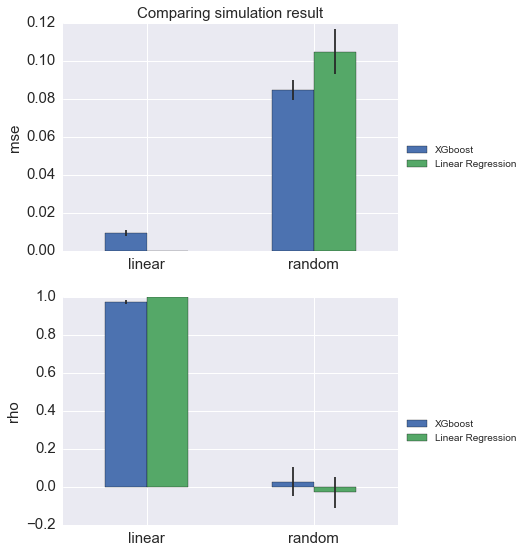

In [4]:
PSL_simulation_result([], [])

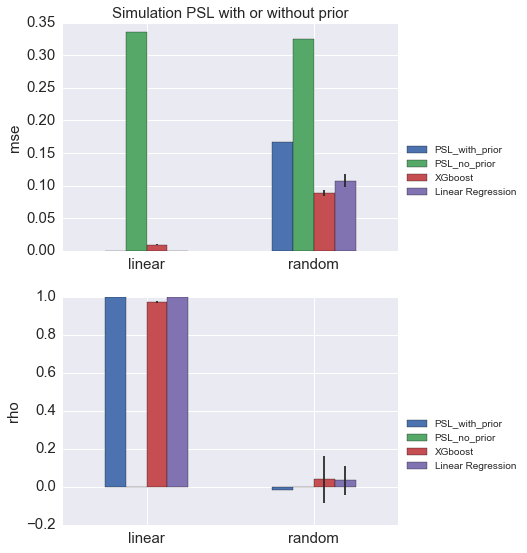

In [10]:
PSL_simulation_result(["yes_prior_no_WL", "no_prior_no_WL"], ["PSL_with_prior", "PSL_no_prior"], 
                     title="Simulation PSL with or without prior")

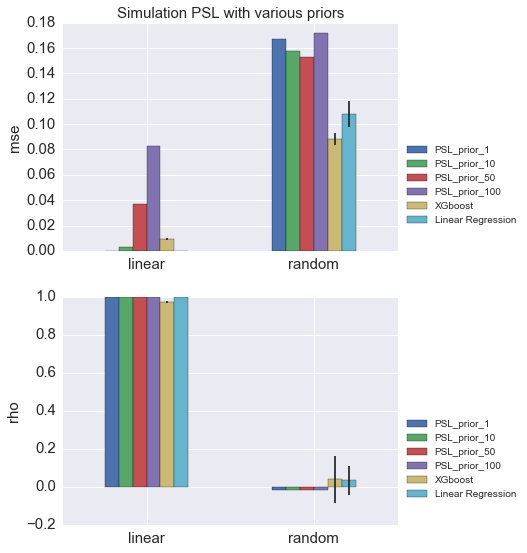

In [5]:
PSL_simulation_result(["yes_prior_no_WL", "yes_prior_no_WL_10", "yes_prior_no_WL_50", "yes_prior_no_WL_100"],
                      ["PSL_prior_1", "PSL_prior_10", "PSL_prior_50", "PSL_prior_100"], 
                       title="Simulation PSL with various priors")

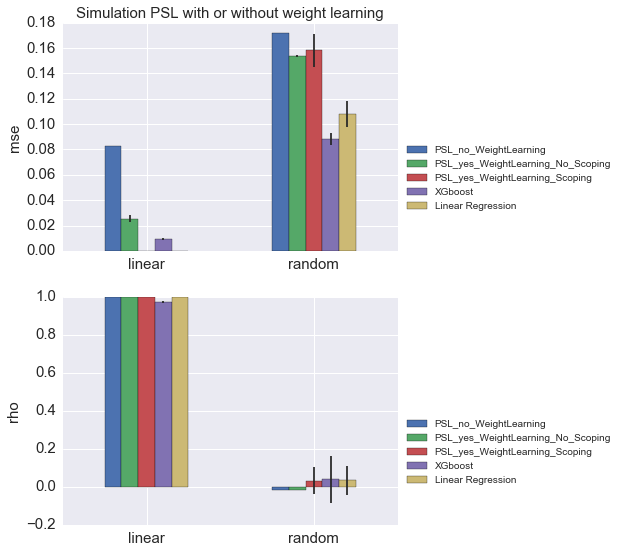

In [7]:
PSL_simulation_result(["yes_prior_no_WL_100", "yes_prior_yes_WL_100", "yes_prior_yes_WL_100_scoping"],
                      ["PSL_no_WeightLearning", "PSL_yes_WeightLearning_No_Scoping", "PSL_yes_WeightLearning_Scoping"], 
                       title="Simulation PSL with or without weight learning")